<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/5_Ensembling_Momentum_Factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensembling Momentum Factors

We have seen a strong cross-sectional momentum effect.

In this notebook we're going to ensemble our momentum factors into a megafactor.

## Load libraries and authenticate

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = TRUE, extra_libraries = c('lubridate', "tibbletime","roll","RcppRoll","Hmisc","Rcpp"), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpWmcaGw/remotes1346454941c/RWLab-rwRtools-9bce833/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘rwRtools/R/sysdata.rda’
* building ‘rwRtools_0.1.34.tar.gz’

── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpWmcaGw/remotes13423ae4525/Robot-Wealth-rsims-2589683/DESCRIPTION’ ... OK
* preparing ‘rsims’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded direct

In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

## Load Coinmetrics daily data

In [3]:
# snippet: rw crypto quickstart v.0.1
quicksetup(pod = "Crypto", path = ".")
prices %>% 
  head()


Set default bucket name to 'crypto_research_pod'



Attempting download of  coinmetrics.csv ...
Transferring coinmetrics.csv ... data is 2.4 Mb please be patient...


ℹ Downloading coinmetrics.csv

✔ Saved coinmetrics.csv to ./coinmetrics.csv  ( 2.4 Mb )





coinmetrics.csv successfully transferred


Rows: 49183 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (2): price_usd, market_cap
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


prices data object transferred and loaded as data.frame to Global Env


ticker,date,price_usd,market_cap
<chr>,<date>,<dbl>,<dbl>
1INCH,2020-12-26,1.6193281,2428992153
1INCH,2020-12-27,1.0723502,1608525301
1INCH,2020-12-28,1.1046742,1657011227
1INCH,2020-12-29,0.8937904,1340685538
1INCH,2020-12-30,1.1013066,1651959828
1INCH,2020-12-31,1.3652374,2047856106


# Calculate Features

In [4]:
# Rolling days since high
rolling_days_since_high_15 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    }, 
    window = 15, na_value = NA), 
  otherwise = NA
)
rolling_days_since_high_20 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    }, 
    window = 20, na_value = NA), 
  otherwise = NA
)

rolling_days_since_high_25 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    }, 
    window = 25, na_value = NA), 
  otherwise = NA
)
rolling_days_since_high_30 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    }, 
    window = 30, na_value = NA), 
  otherwise = NA
)


features_wide <- prices %>%
  group_by(ticker) %>%
  arrange(date) %>%
  # Price momo factor
  mutate(
    mom_10 = log(price_usd / lag(price_usd, n = 10)),
    mom_15 = log(price_usd / lag(price_usd, n = 15)),
    mom_20 = log(price_usd / lag(price_usd, n = 20)),
    mom_25 = log(price_usd / lag(price_usd, n = 25))
  ) %>%
  # Price to SMA factor
  mutate(
    psma_15 = price_usd / roll_meanr(price_usd, 15) - 1,
    psma_20 = price_usd / roll_meanr(price_usd, 20) - 1,
    psma_25 = price_usd / roll_meanr(price_usd, 25) - 1,
    psma_30 = price_usd / roll_meanr(price_usd, 30) - 1,
  ) %>%
  # SMA ratio factor 
  mutate(
    smaf_2_20 = roll_meanr(price_usd, 2) / roll_meanr(price_usd, 20) - 1,
    smaf_3_20 = roll_meanr(price_usd, 3) / roll_meanr(price_usd, 20) - 1,
    smaf_3_25 = roll_meanr(price_usd, 3) / roll_meanr(price_usd, 25) - 1,
    smaf_5_30 = roll_meanr(price_usd, 5) / roll_meanr(price_usd, 30) - 1.
  ) %>%
  # Rolling price zscore over recent history
  mutate(
    rrp_15 = (price_usd - roll_meanr(price_usd, n = 15)) / roll_sdr(price_usd, n = 15),
    rrp_20 = (price_usd - roll_meanr(price_usd, n = 20)) / roll_sdr(price_usd, n = 20),
    rrp_25 = (price_usd - roll_meanr(price_usd, n = 25)) / roll_sdr(price_usd, n = 25),
    rrp_30 = (price_usd - roll_meanr(price_usd, n = 30)) / roll_sdr(price_usd, n = 20)
  ) %>%
  # Rolling days since recent high
  mutate(
    dsh_15 = -rolling_days_since_high_15(price_usd),
    dsh_20 = -rolling_days_since_high_20(price_usd),
    dsh_25 = -rolling_days_since_high_25(price_usd),
    dsh_30 = -rolling_days_since_high_30(price_usd),
  ) %>%
  # Calculate returns
  mutate(fwd_log_return_1 = log(lead(price_usd) / price_usd),
         fwd_log_return_2 = log(lead(price_usd,2) / lead(price_usd, 1)),
         fwd_log_return_3 = log(lead(price_usd,3) / lead(price_usd, 2)),
         fwd_log_return_4 = log(lead(price_usd,4) / lead(price_usd, 3)),
         fwd_log_return_5 = log(lead(price_usd,5) / lead(price_usd, 4)),
         fwd_log_return_6 = log(lead(price_usd,6) / lead(price_usd, 5)),
         fwd_log_return_7 = log(lead(price_usd,7) / lead(price_usd, 6)),
         fwd_return_1 = lead(price_usd,1) / price_usd - 1,
         fwd_return_2 = lead(price_usd,2) / lead(price_usd, 1) - 1,
         fwd_return_3 = lead(price_usd,3) / lead(price_usd, 2) - 1,
         fwd_return_4 = lead(price_usd,4) / lead(price_usd, 3) - 1,
         fwd_return_5 = lead(price_usd,5) / lead(price_usd, 4) - 1,
         fwd_return_6 = lead(price_usd,6) / lead(price_usd, 5) - 1,
         fwd_return_7 = lead(price_usd,7) / lead(price_usd, 6) - 1
  ) %>%
  na.omit() %>%
  ungroup() 

# Creating research universe

See Notebook 1 for details on how we construct the universe.

In [5]:
create_universe <- function(prices, n=10, min_constituents = 10) {
  # snippet: rw crypto remove stablecoins v0.2
  # Remove stablecoins from data set
  prices <- prices %>% 
    filter(!ticker %in% c('BUSD','DAI','GUSD','HUSD','PAX','SAI','TUSD','USDC','USDK','USDT','USDT_ETH','USDT_OMNI','USDT_TRX', 'XAUT')) 
  # snippet: rw crypto remove duplicates v0.1
  # Remove duplicate protocol coins from data set
  prices <- prices %>% 
    filter(!ticker %in% c('BNB_ETH','LEO_EOS','RENBTC', 'WNXM', 'WETH', 'WBTC'))

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(date)) %>%
    pull(mindate)

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  prices %>%
    group_by(date) %>%
    mutate(cap_rank = row_number(desc(market_cap))) %>%
    arrange(date) %>%
    group_by(ticker) %>%
    mutate(is_index = lag(cap_rank) <= n & date >= start_date) %>%
    na.omit() %>%
    ungroup()
}

In [6]:
universe <- features_wide %>%
  create_universe(n = 10, min_constituents = 10)

universe %>%
  head()

ticker,date,price_usd,market_cap,mom_10,mom_15,mom_20,mom_25,psma_15,psma_20,⋯,fwd_log_return_7,fwd_return_1,fwd_return_2,fwd_return_3,fwd_return_4,fwd_return_5,fwd_return_6,fwd_return_7,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
BTC,2010-08-16,0.0655,244943.8,0.060231230,0.06953828,0.11093981,0.1135404,0.0250858746,0.02298150,⋯,-0.015576542,0.068702290,-0.028571429,-0.019117647,-0.017991004,0.013740458,-0.007093541,-0.015455855,1,FALSE
BTC,2010-08-17,0.0700,262223.5,0.170890935,0.15415068,0.17246573,0.1443180,0.0841996850,0.08387701,⋯,0.001385575,-0.028571429,-0.019117647,-0.017991004,0.013740458,-0.007093541,-0.015455855,0.001386535,1,FALSE
BTC,2010-08-18,0.0680,255183.6,0.110274530,0.12496065,-0.02755794,0.2205733,0.0446066123,0.05446018,⋯,-0.003081667,-0.019117647,-0.017991004,0.013740458,-0.007093541,-0.015455855,0.001386535,-0.003076923,1,FALSE
BTC,2010-08-19,0.0667,250755.3,-0.053988310,0.15687688,0.03110268,0.2774276,0.0145738079,0.03266593,⋯,-0.011249552,-0.017991004,0.013740458,-0.007093541,-0.015455855,0.001386535,-0.003076923,-0.011186513,1,FALSE
BTC,2010-08-20,0.0655,246876.0,-0.056953465,0.07117628,-0.03075573,0.1566985,-0.0082052515,0.01569577,⋯,0.014331219,0.013740458,-0.007093541,-0.015455855,0.001386535,-0.003076923,-0.011186513,0.014434403,1,FALSE
BTC,2010-08-21,0.0664,250842.6,-0.008995563,0.07387814,0.08318519,0.1245867,0.0006459594,0.02543806,⋯,-0.006172859,-0.007093541,-0.015455855,0.001386535,-0.003076923,-0.011186513,0.014434403,-0.006153846,1,FALSE


# Analyzing The 20 day momentum factor

Each day:
 - Rank each coin by its 20 day momentum 
 - Group by rank
 - Plot the mean log return n days after for each rank. 

`summarise()` has grouped output by 'rank'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'rank'. You can override using the
`.groups` argument.


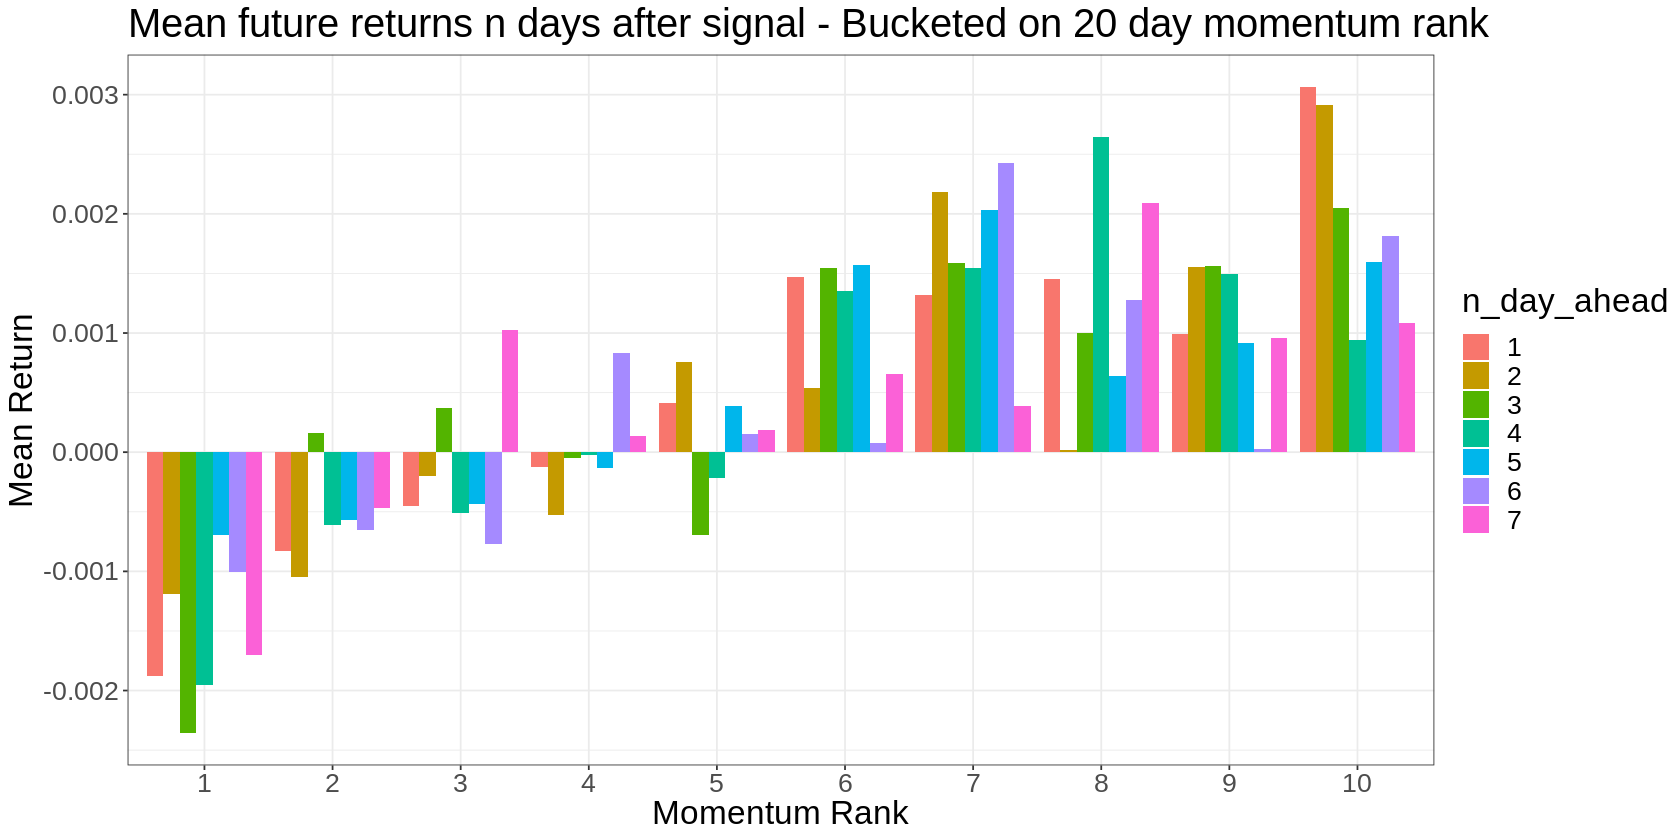

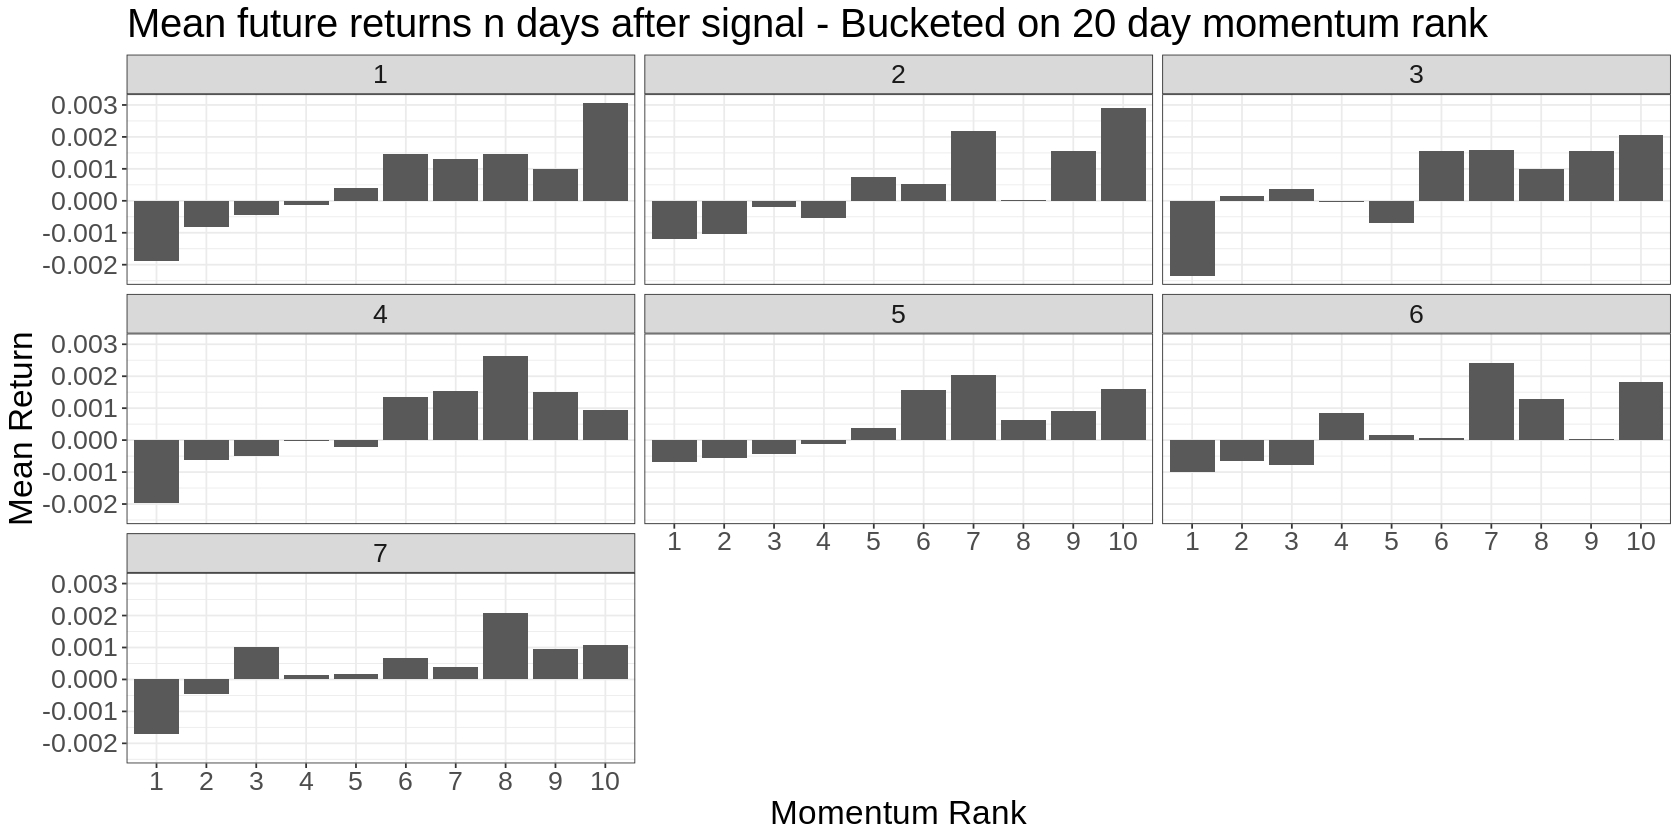

In [7]:
universe %>%
  filter(is_index == TRUE) %>%
  group_by(date) %>%
  mutate(rank = factor(row_number(mom_20))) %>%
  pivot_longer(starts_with('fwd_log_return_'), names_to = 'target', values_to = 'logreturn') %>%
  mutate(n_day_ahead = substring(target, 16)) %>%
  group_by(rank, n_day_ahead) %>%
  summarise(mean_fwd_log_ret = mean(logreturn)) %>%
  ggplot(aes(x=rank, y=mean_fwd_log_ret, fill=n_day_ahead)) + geom_bar(stat='identity', position = 'dodge') + 
  labs(
    title = 'Mean future returns n days after signal - Bucketed on 20 day momentum rank',
    x = 'Momentum Rank',
    y = 'Mean Return'
  )

universe %>%
  filter(is_index == TRUE) %>%
  group_by(date) %>%
  mutate(rank = factor(row_number(mom_20))) %>%
  pivot_longer(starts_with('fwd_log_return_'), names_to = 'target', values_to = 'logreturn') %>%
  mutate(n_day_ahead = substring(target, 16)) %>%
  group_by(rank, n_day_ahead) %>%
  summarise(mean_fwd_log_ret = mean(logreturn)) %>%
  ggplot(aes(x=rank, y=mean_fwd_log_ret)) + geom_bar(stat='identity', position = 'dodge') + facet_wrap(~n_day_ahead) +
  labs(
    title = 'Mean future returns n days after signal - Bucketed on 20 day momentum rank',
    x = 'Momentum Rank',
    y = 'Mean Return'
  )  

It's a persistent effect, even if we take ages to act!!

Let's plot this separately for each year in our sample.

`summarise()` has grouped output by 'year', 'rank'. You can override using the
`.groups` argument.


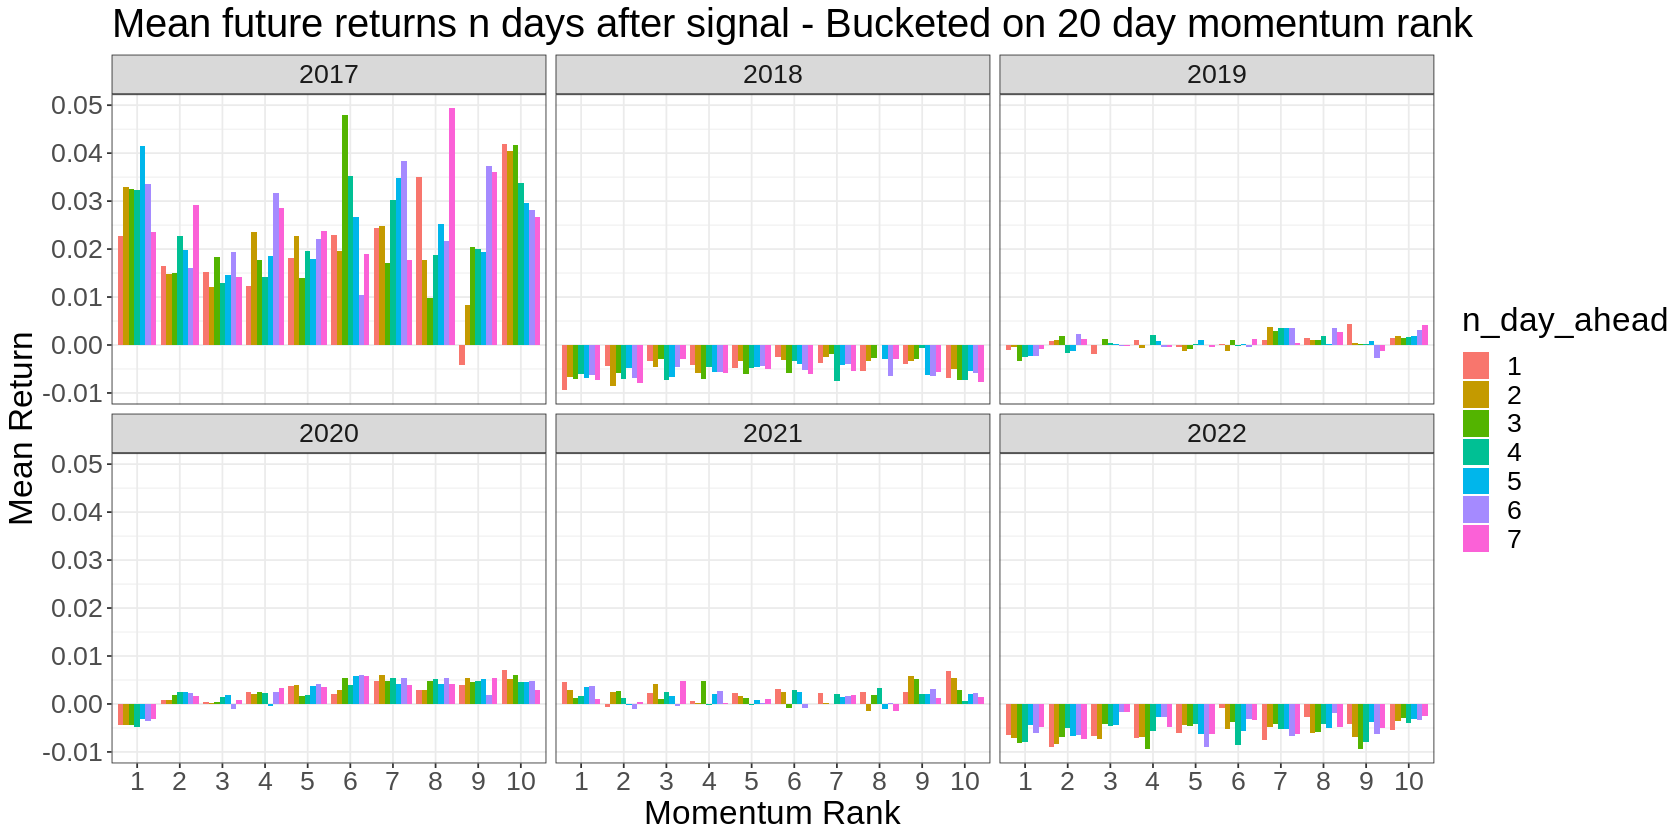

In [8]:
universe %>%
  mutate(year = factor(year(date))) %>%
  filter(is_index == TRUE) %>%
  group_by(date) %>%
  mutate(rank = factor(row_number(mom_20))) %>%
  pivot_longer(starts_with('fwd_log_return_'), names_to = 'target', values_to = 'logreturn') %>%
  mutate(n_day_ahead = substring(target, 16)) %>%
  group_by(year, rank, n_day_ahead) %>%
  summarise(mean_fwd_log_ret = mean(logreturn)) %>%
  ggplot(aes(x=rank, y=mean_fwd_log_ret, fill=n_day_ahead)) + 
    geom_bar(stat='identity', position = 'dodge') + 
    facet_wrap(~year) +
  labs(
    title = 'Mean future returns n days after signal - Bucketed on 20 day momentum rank',
    x = 'Momentum Rank',
    y = 'Mean Return'
  )



# Creating a factor time series

Now, we're going to construct a number of factor time series. 

Weight all assets in proportion to their rank.


`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.


n_day_ahead,meanreturn,vol,ir
<chr>,<dbl>,<dbl>,<dbl>
1,0.5533846,0.3645685,1.5179166
2,0.4746878,0.3547752,1.3379959
4,0.4468241,0.3511752,1.2723681
3,0.4391323,0.3570556,1.2298710
6,0.3161141,0.3581131,0.8827213
5,0.3108851,0.3503989,0.8872320
7,0.3012239,0.3434265,0.8771131


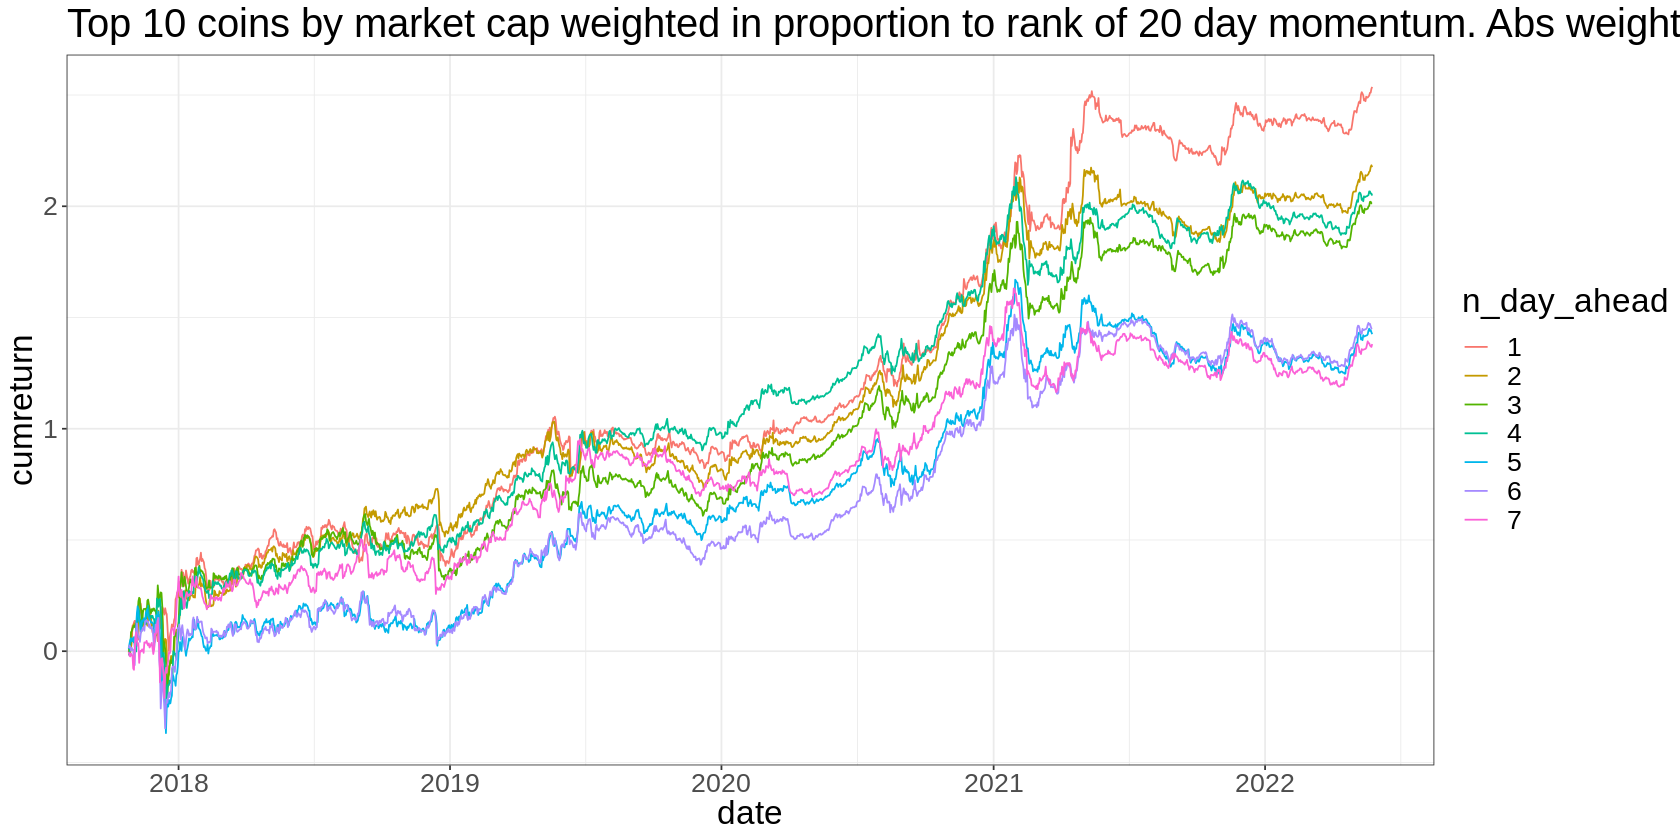

In [9]:
factor_returns <- universe %>%
  filter(is_index) %>%
  group_by(date) %>%
  mutate(rank = factor(row_number(mom_20))) %>%
  pivot_longer(starts_with('fwd_return_'), names_to = 'target', values_to = 'simplereturn') %>%
  mutate(n_day_ahead = substring(target, 12)) %>%
  group_by(date, n_day_ahead) %>%
  mutate(
    rank = row_number(mom_20),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = simplereturn * scaled_weight
  )  %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(n_day_ahead) %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) 

factor_returns %>% 
  ggplot(aes(x=date, y=cumreturn, color = n_day_ahead)) +
    geom_line() +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank of 20 day momentum. Abs weights scaled to 1. Cum log returns')

factor_returns %>% 
  group_by(n_day_ahead) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    vol= sd(log_factor_return) * sqrt(365), 
    ir = meanreturn / vol
  ) %>% 
  arrange(desc(meanreturn))

`summarise()` has grouped output by 'date', 'lookback'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,n_day_ahead,meanreturn,vol,ir
<chr>,<chr>,<dbl>,<dbl>,<dbl>
mom_15,1,0.6520040,0.3626348,1.797963
mom_10,1,0.6151652,0.3662873,1.679461
mom_15,2,0.5590855,0.3439358,1.625552
mom_20,1,0.5533846,0.3645685,1.517917
mom_25,1,0.5303796,0.3479129,1.524461
mom_20,2,0.4746878,0.3547752,1.337996
mom_25,3,0.4725221,0.3479367,1.358069
mom_15,3,0.4701135,0.3563318,1.319314
mom_20,3,0.4391323,0.3570556,1.229871


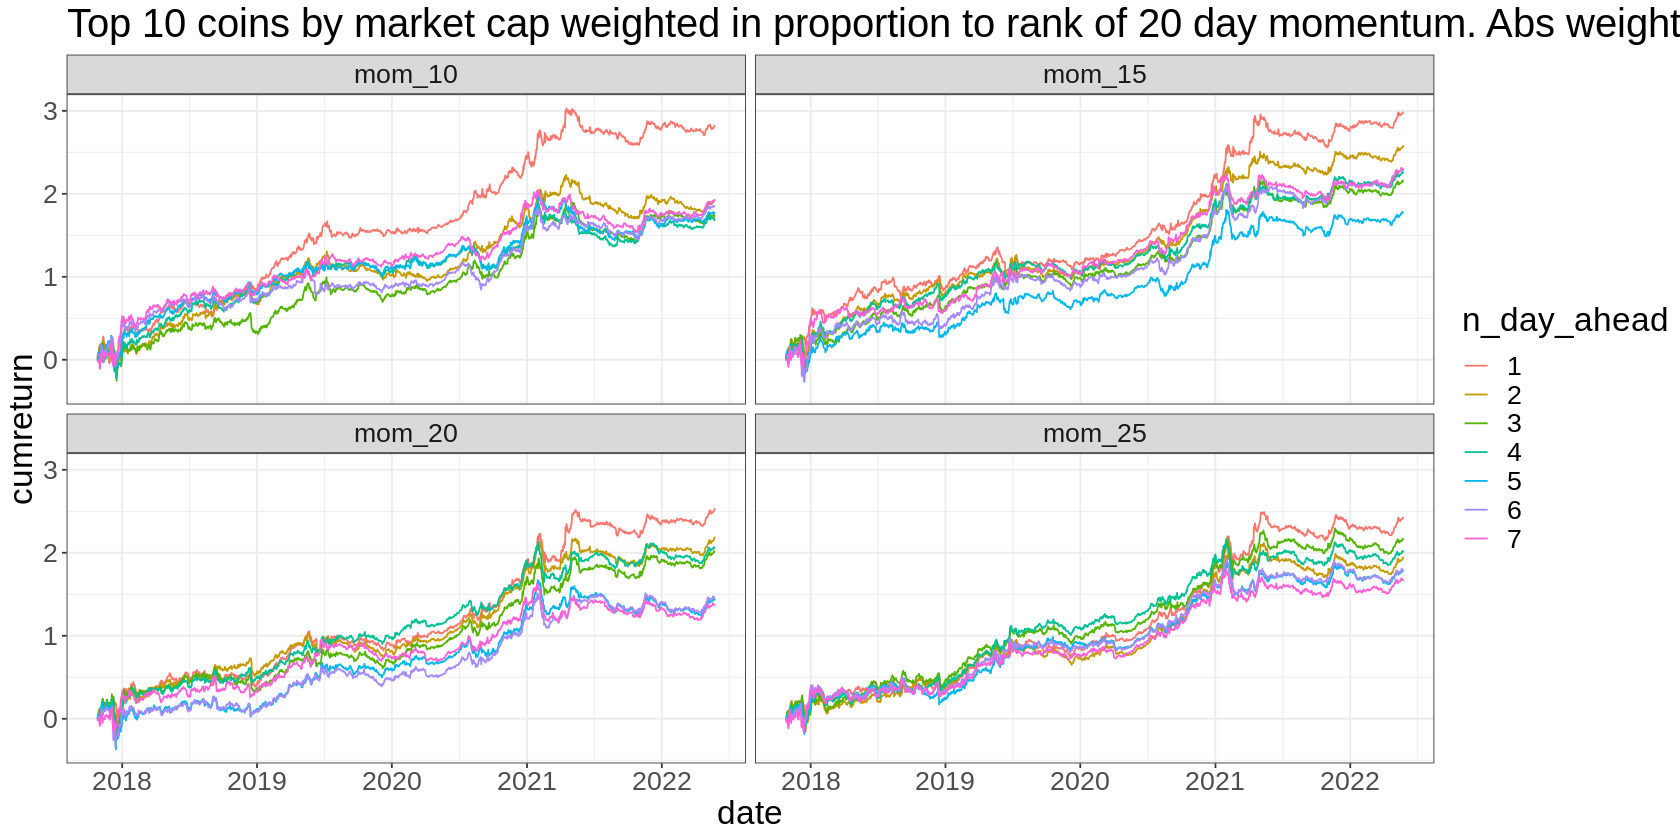

In [10]:
factor_lookback_returns <- universe %>%
  pivot_longer(starts_with('mom_'), names_to = 'lookback', values_to = 'momentum') %>%
  filter(is_index) %>%
  group_by(date, lookback) %>%
  mutate(rank = factor(row_number(momentum))) %>%
  pivot_longer(starts_with('fwd_return_'), names_to = 'target', values_to = 'simplereturn') %>%
  mutate(n_day_ahead = substring(target, 12)) %>%
  group_by(date, lookback, n_day_ahead) %>%
  mutate(
    rank = row_number(momentum),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = simplereturn * scaled_weight
  )  %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback, n_day_ahead) %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) 

factor_lookback_returns %>% 
  ggplot(aes(x=date, y=cumreturn, color = n_day_ahead)) +
    geom_line() +
    facet_wrap(~lookback) +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank of 20 day momentum. Abs weights scaled to 1. Cum log returns')

factor_lookback_returns %>% 
  filter(n_day_ahead <= 3) %>%
  group_by(lookback, n_day_ahead) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    vol= sd(log_factor_return) * sqrt(365), 
    ir = meanreturn / vol
  ) %>% 
  arrange(desc(meanreturn))

# Price to SMA Factor

`summarise()` has grouped output by 'date', 'lookback'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,n_day_ahead,meanreturn,vol,ir
<chr>,<chr>,<dbl>,<dbl>,<dbl>
psma_20,1,0.7083099,0.3628882,1.951868
psma_25,1,0.6648155,0.3645191,1.823815
psma_15,1,0.6496293,0.3680926,1.764853
psma_30,1,0.6255000,0.3616568,1.729540
psma_20,2,0.5814517,0.3527494,1.648342
psma_25,2,0.5608633,0.3539602,1.584538
psma_15,2,0.5187404,0.3505929,1.479609
psma_30,2,0.5012263,0.3534166,1.418231
psma_20,3,0.4843274,0.3572237,1.355810


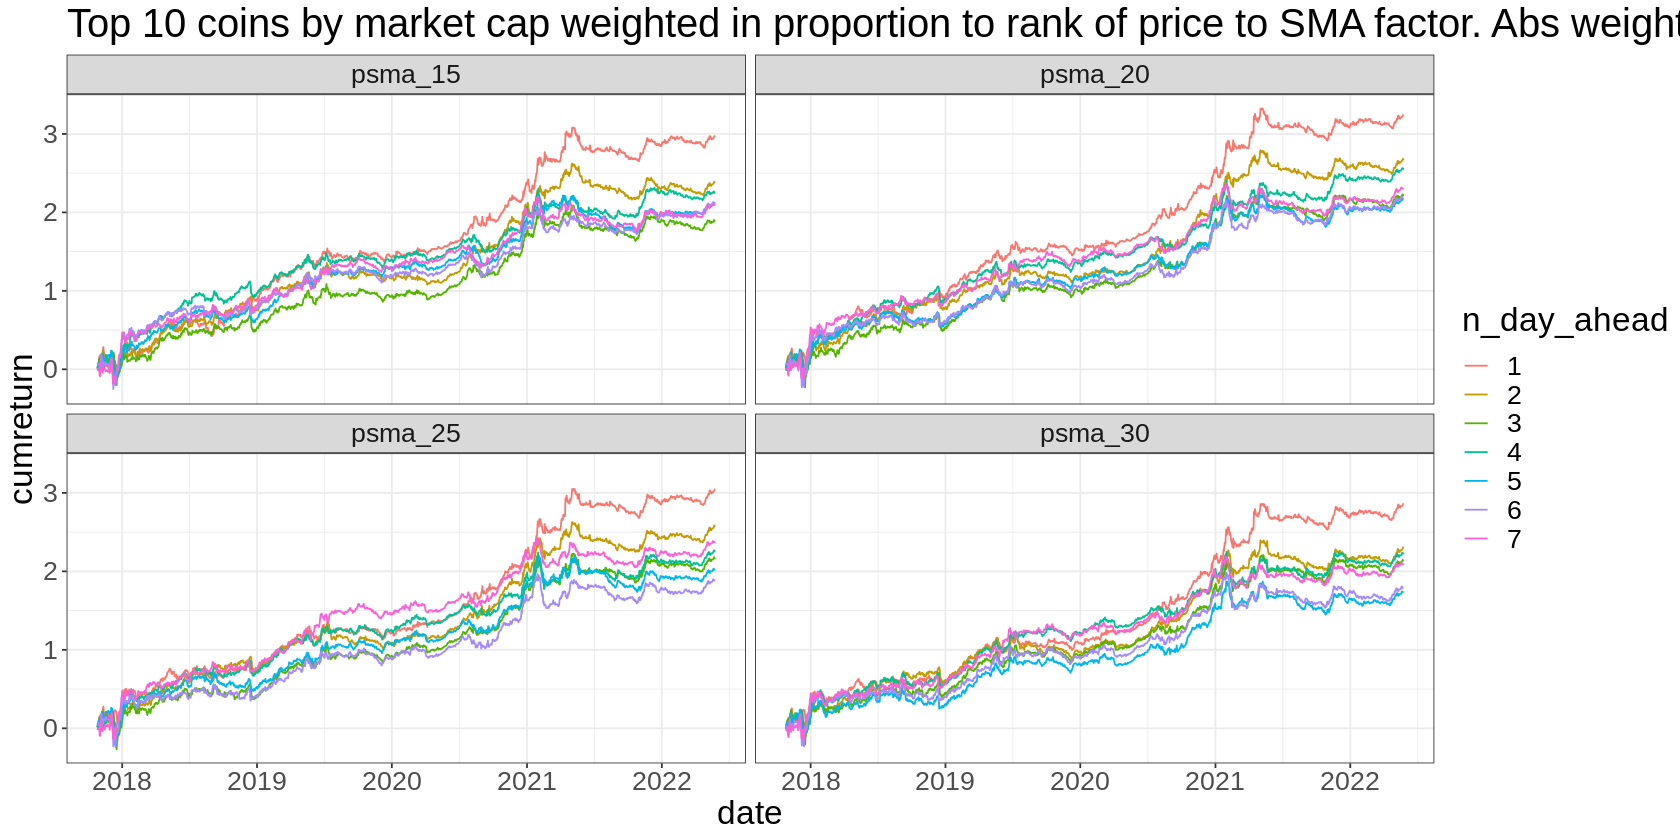

In [11]:
factor_lookback_returns <- universe %>%
  pivot_longer(starts_with('psma'), names_to = 'lookback', values_to = 'momentum') %>%
  filter(is_index) %>%
  group_by(date, lookback) %>%
  mutate(rank = factor(row_number(momentum))) %>%
  pivot_longer(starts_with('fwd_return_'), names_to = 'target', values_to = 'simplereturn') %>%
  mutate(n_day_ahead = substring(target, 12)) %>%
  group_by(date, lookback, n_day_ahead) %>%
  mutate(
    rank = row_number(momentum),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = simplereturn * scaled_weight
  )  %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback, n_day_ahead) %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) 

factor_lookback_returns %>% 
  ggplot(aes(x=date, y=cumreturn, color = n_day_ahead)) +
    geom_line() +
    facet_wrap(~lookback) +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank of price to SMA factor. Abs weights scaled to 1. Cum log returns')

factor_lookback_returns %>% 
  filter(n_day_ahead <= 3) %>%
  group_by(lookback, n_day_ahead) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    vol= sd(log_factor_return) * sqrt(365), 
    ir = meanreturn / vol
  ) %>% 
  arrange(desc(meanreturn))

# SMA Ratio Factor

`summarise()` has grouped output by 'date', 'lookback'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,n_day_ahead,meanreturn,vol,ir
<chr>,<chr>,<dbl>,<dbl>,<dbl>
smaf_3_20,1,0.6336692,0.3644199,1.738844
smaf_2_20,1,0.6101483,0.3639912,1.676272
smaf_3_25,1,0.5993006,0.3612777,1.658836
smaf_3_20,2,0.5837687,0.3487309,1.673980
smaf_2_20,2,0.5769652,0.3502097,1.647485
smaf_5_30,1,0.5591481,0.3609574,1.549069
smaf_3_25,2,0.5547364,0.3533979,1.569722
smaf_2_20,3,0.5205872,0.3480685,1.495646
smaf_3_20,3,0.5183156,0.3548278,1.460753


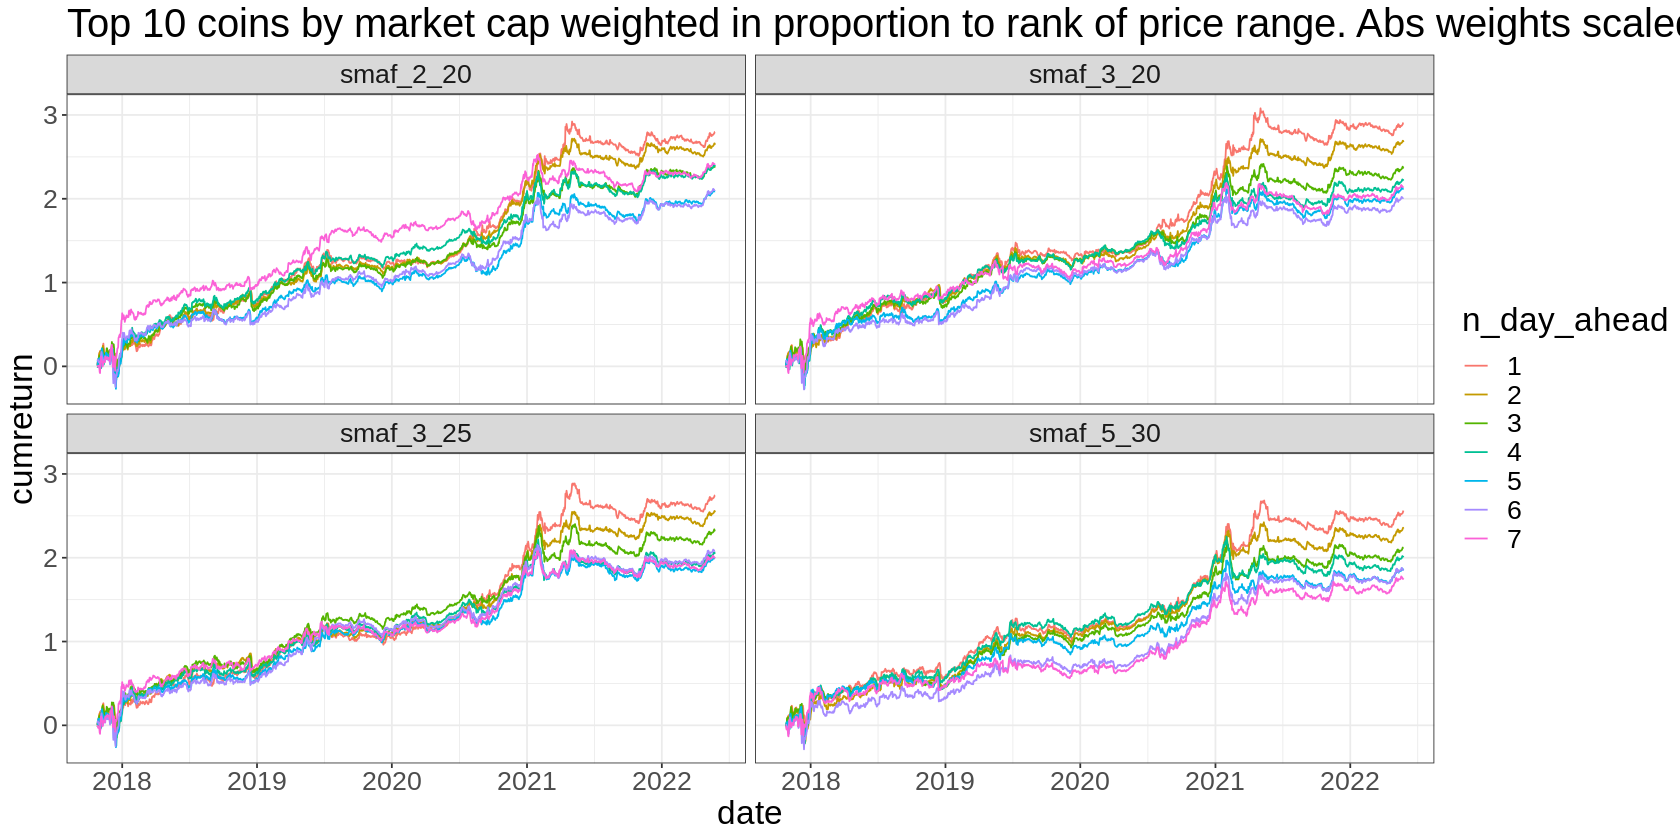

In [12]:
factor_lookback_returns <- universe %>%
  pivot_longer(starts_with('smaf'), names_to = 'lookback', values_to = 'momentum') %>%
  filter(is_index) %>%
  group_by(date, lookback) %>%
  mutate(rank = factor(row_number(momentum))) %>%
  pivot_longer(starts_with('fwd_return_'), names_to = 'target', values_to = 'simplereturn') %>%
  mutate(n_day_ahead = substring(target, 12)) %>%
  group_by(date, lookback, n_day_ahead) %>%
  mutate(
    rank = row_number(momentum),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = simplereturn * scaled_weight
  )  %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback, n_day_ahead) %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) 

factor_lookback_returns %>% 
  ggplot(aes(x=date, y=cumreturn, color = n_day_ahead)) +
    geom_line() +
    facet_wrap(~lookback) +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank of price range. Abs weights scaled to 1. Cum log returns')

factor_lookback_returns %>% 
  filter(n_day_ahead <= 3) %>%
  group_by(lookback, n_day_ahead) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    vol= sd(log_factor_return) * sqrt(365), 
    ir = meanreturn / vol
  ) %>% 
  arrange(desc(meanreturn))

# Price Range Factor

`summarise()` has grouped output by 'date', 'lookback'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,n_day_ahead,meanreturn,vol,ir
<chr>,<chr>,<dbl>,<dbl>,<dbl>
rrp_15,1,0.8296397,0.3557785,2.331899
rrp_20,1,0.8265192,0.3466013,2.384640
rrp_25,1,0.7954956,0.3462400,2.297527
rrp_30,1,0.7267742,0.3437785,2.114077
rrp_25,2,0.5081067,0.3363838,1.510497
rrp_20,2,0.4462497,0.3304779,1.350316
rrp_30,2,0.4408668,0.3217144,1.370367
rrp_20,3,0.4003061,0.3301307,1.212569
rrp_25,3,0.3947575,0.3374219,1.169923


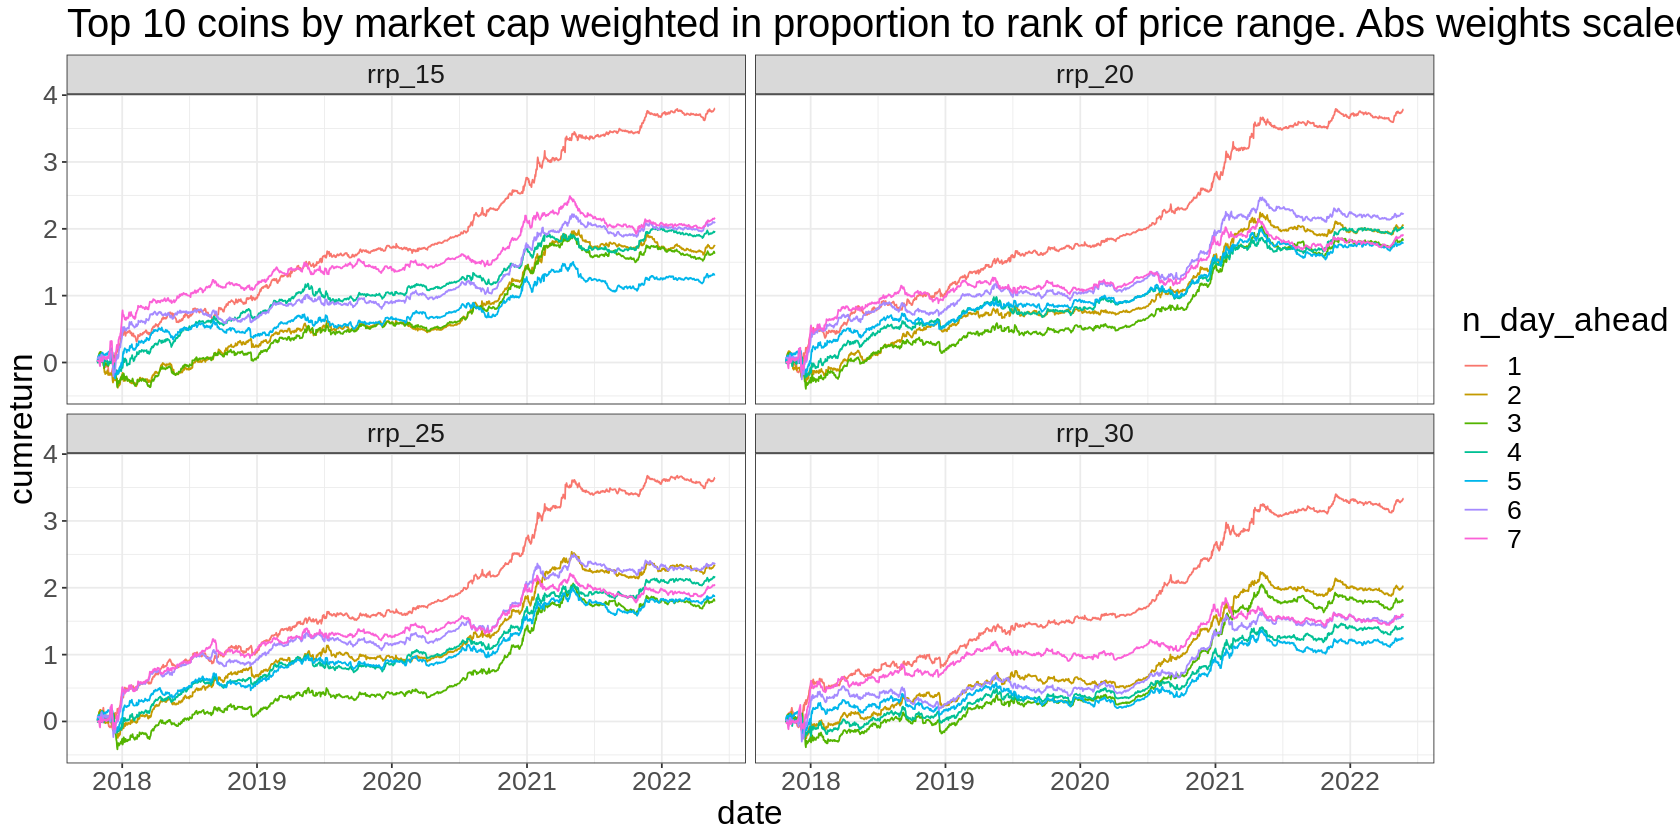

In [13]:
factor_lookback_returns <- universe %>%
  pivot_longer(starts_with('rrp'), names_to = 'lookback', values_to = 'momentum') %>%
  filter(is_index) %>%
  group_by(date, lookback) %>%
  mutate(rank = factor(row_number(momentum))) %>%
  pivot_longer(starts_with('fwd_return_'), names_to = 'target', values_to = 'simplereturn') %>%
  mutate(n_day_ahead = substring(target, 12)) %>%
  group_by(date, lookback, n_day_ahead) %>%
  mutate(
    rank = row_number(momentum),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = simplereturn * scaled_weight
  )  %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback, n_day_ahead) %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) 

factor_lookback_returns %>% 
  ggplot(aes(x=date, y=cumreturn, color = n_day_ahead)) +
    geom_line() +
    facet_wrap(~lookback) +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank of price range. Abs weights scaled to 1. Cum log returns')

factor_lookback_returns %>% 
  filter(n_day_ahead <= 3) %>%
  group_by(lookback, n_day_ahead) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    vol= sd(log_factor_return) * sqrt(365), 
    ir = meanreturn / vol
  ) %>% 
  arrange(desc(meanreturn))

# Rolling Days Since High Factor

`summarise()` has grouped output by 'date', 'lookback'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'lookback'. You can override using the
`.groups` argument.


lookback,n_day_ahead,meanreturn,vol,ir
<chr>,<chr>,<dbl>,<dbl>,<dbl>
dsh_15,1,0.5244904,0.3205242,1.6363517
dsh_25,1,0.4897041,0.3256043,1.5039856
dsh_30,1,0.4678162,0.3251243,1.4388842
dsh_20,1,0.4363980,0.3237681,1.3478723
dsh_15,2,0.2693248,0.3221017,0.8361485
dsh_25,2,0.2297499,0.3190925,0.7200104
dsh_20,2,0.2226509,0.3227199,0.6899199
dsh_30,2,0.1940815,0.3192162,0.6079939
dsh_15,3,0.1547305,0.3199477,0.4836120


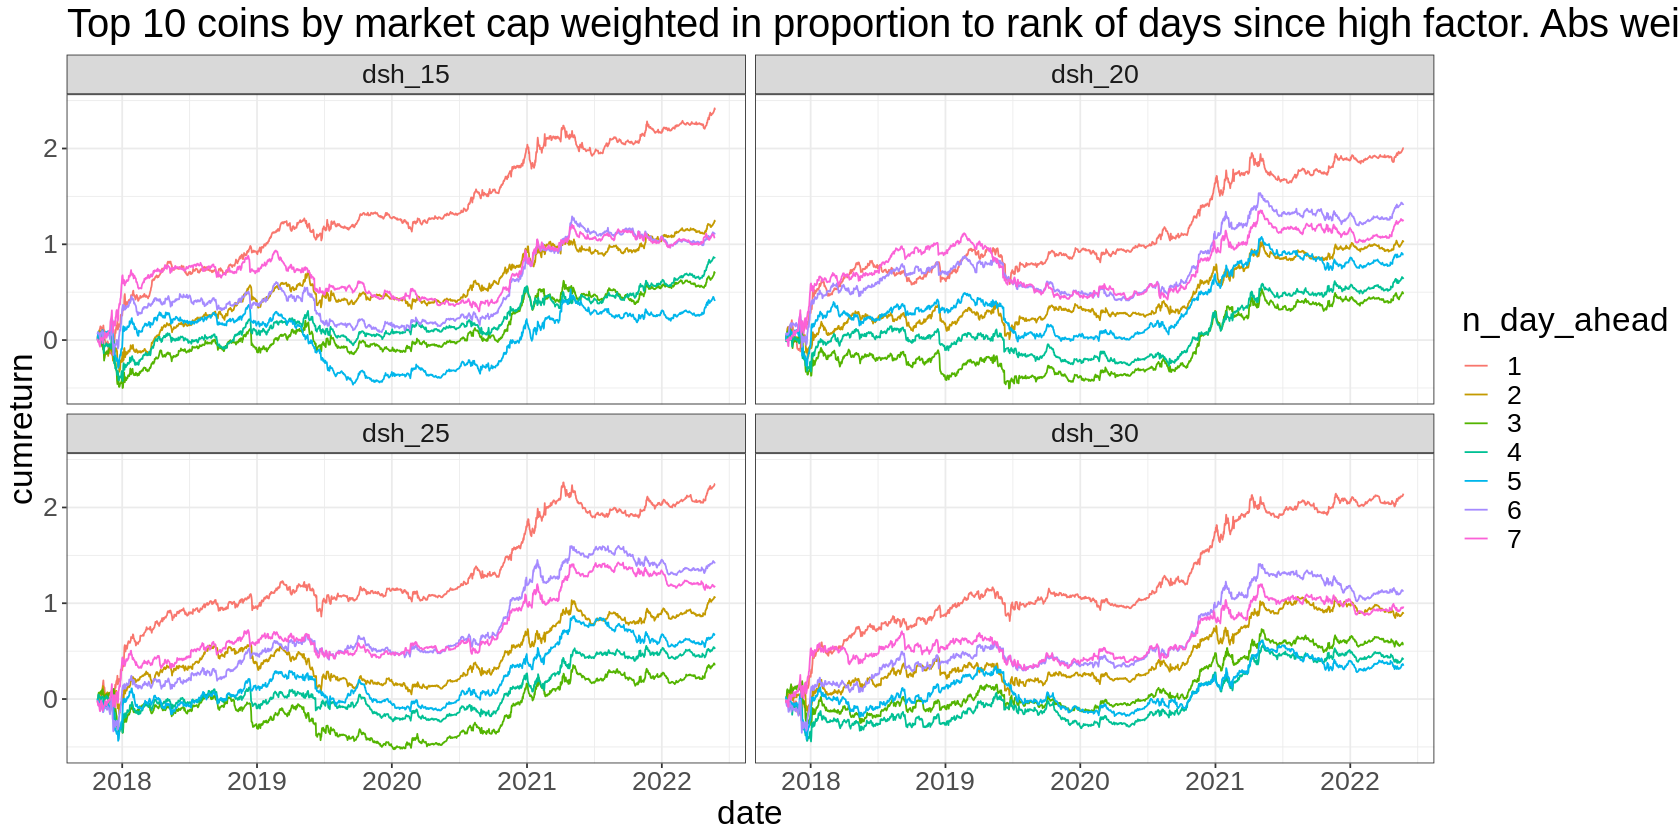

In [14]:
factor_lookback_returns <- universe %>%
  pivot_longer(starts_with('dsh'), names_to = 'lookback', values_to = 'momentum') %>%
  filter(is_index) %>%
  group_by(date, lookback) %>%
  mutate(rank = factor(row_number(momentum))) %>%
  pivot_longer(starts_with('fwd_return_'), names_to = 'target', values_to = 'simplereturn') %>%
  mutate(n_day_ahead = substring(target, 12)) %>%
  group_by(date, lookback, n_day_ahead) %>%
  mutate(
    rank = row_number(momentum),
    weight = rank - mean(rank),
    scaled_weight = weight / sum(abs(weight)),
    weighted_fwd_returns = simplereturn * scaled_weight
  )  %>%
  summarise(log_factor_return = log(sum(weighted_fwd_returns) + 1)) %>%
  group_by(lookback, n_day_ahead) %>%
  arrange(date) %>%
  mutate(cumreturn = cumsum(log_factor_return)) 

factor_lookback_returns %>% 
  ggplot(aes(x=date, y=cumreturn, color = n_day_ahead)) +
    geom_line() +
    facet_wrap(~lookback) +
    ggtitle('Top 10 coins by market cap weighted in proportion to rank of days since high factor. Abs weights scaled to 1. Cum log returns')

factor_lookback_returns %>% 
  filter(n_day_ahead <= 3) %>%
  group_by(lookback, n_day_ahead) %>%
  summarise(
    meanreturn = mean(log_factor_return) * 365,
    vol= sd(log_factor_return) * sqrt(365), 
    ir = meanreturn / vol
  ) %>% 
  arrange(desc(meanreturn))

# Mega-Factor


`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.


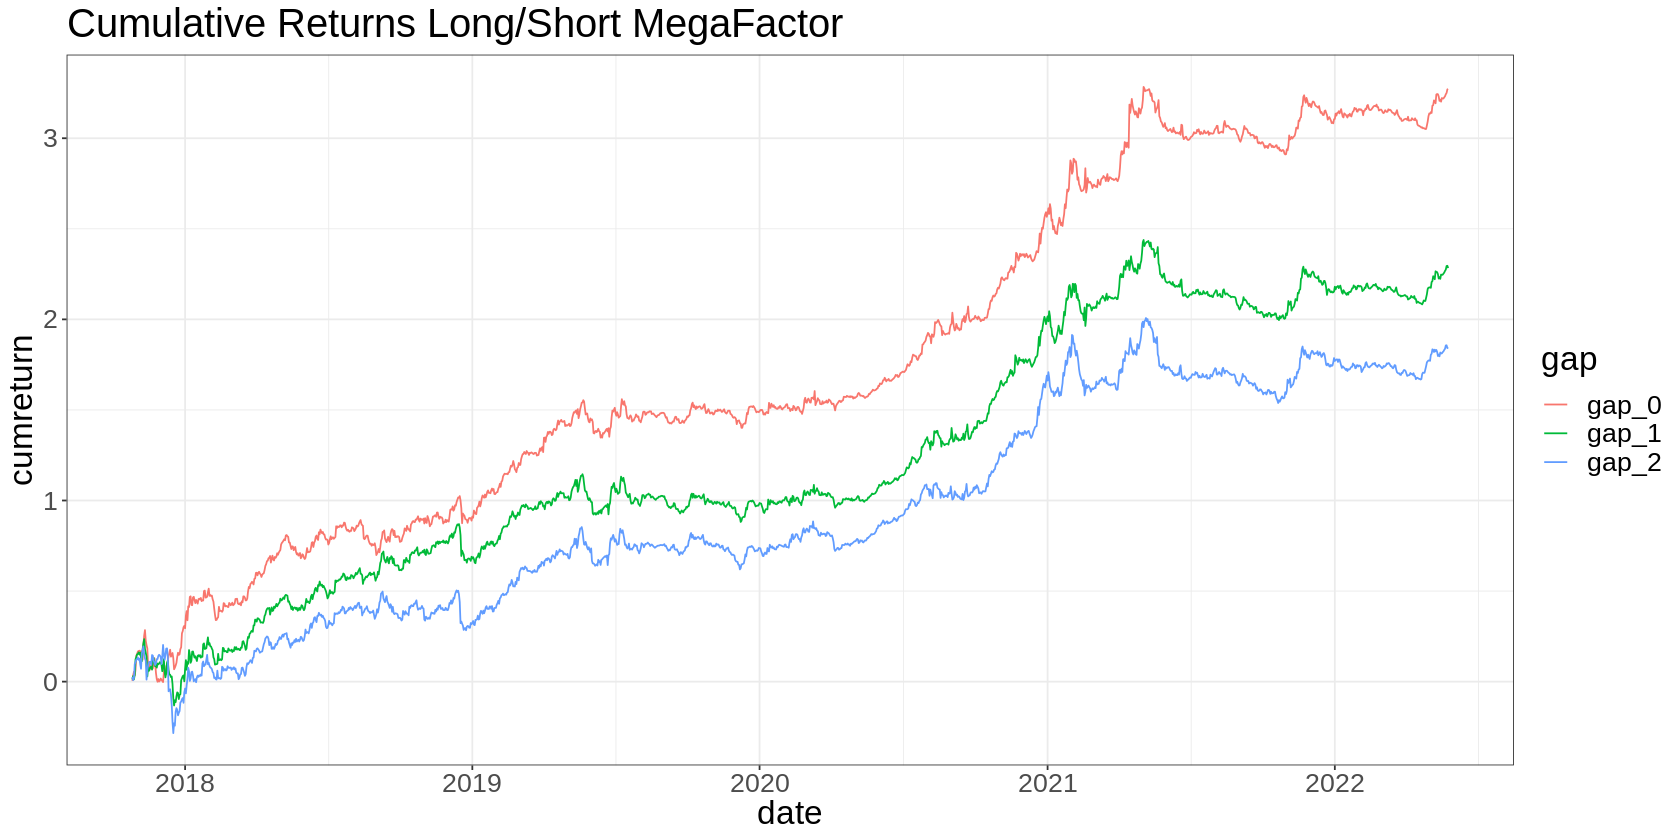

In [15]:
mom_ranks <- universe %>%
  pivot_longer(
    c(starts_with('mom_'), starts_with('psma_'), starts_with('smaf_'), starts_with('rrp_'), starts_with('dsh_')), 
    names_to = 'feature', 
    values_to = 'value'
  ) %>%
  filter(is_index) %>%
  group_by(date, feature) %>%
  mutate(
    rank = row_number(value),
    weight = rank - mean(rank),
    scaled_weight = weight/sum(abs(weight)),
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  )

megafactor <- mom_ranks %>%
  group_by(date, ticker) %>%
  summarise(megafactor = mean(rank)) 

megafactor %>%
  inner_join(universe,  by = c('ticker','date')) %>%
  mutate(
    weight = megafactor - mean(megafactor),
    scaled_weight = weight/sum(abs(weight)),
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  ) %>%
  group_by(date) %>%
  summarise(
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
    log_factor_return_2 = log(sum(weighted_fwd_return_2) + 1),
    log_factor_return_3 = log(sum(weighted_fwd_return_3) + 1)
  ) %>%
  arrange(date) %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
    gap_1 = cumsum(log_factor_return_2),
    gap_2 = cumsum(log_factor_return_3)
  ) %>%
  # Rolling returns
  mutate(
    rolling_gap_0 = roll_meanr(log_factor_return_1, 90) * 365,
    rolling_gap_1 = roll_meanr(log_factor_return_2, 90) * 365,
    rolling_gap_2 = roll_meanr(log_factor_return_3, 90) * 365
  ) %>%
  pivot_longer(starts_with('gap_'), names_to = 'gap', values_to = 'cumreturn') %>%
  ggplot(aes(x=date, y=cumreturn, color = gap)) +
    geom_line() +
    ggtitle('Cumulative Returns Long/Short MegaFactor')


# What's Next?

- Simulation + trading rules
- Tilt exposure based on time series momentum?
